<h1>MIC Data Exploration Tools</h1>

With the Vitek Database built, we need a set of tools for easily querying the database and extracting some basic insights. The Microbiology Data Portal, a web application that will provide a GUI for accessing this dataset, will directly use these tools on the server side in response to the clients requests. I will build these tools however, with the ability to use them independant of the web application. 

The tool kit is split into two classes: ExtractData and ProcessData.

<h2>ExtractData</h2>

Python Dependencies:
* PyMongo
* Pickles
* Re

This first class is initiated with a Mongodb client, which can be created using the PyMongo library, and the database name. Once an object of this class is created we can call the 'get_mic_data' method, passing in the name of the organism we are interested in. This will return an array of dictionary objects, each containing a unique isolate and its MIC summary data. That array can then be passed to the 'to_pickle' method, along with a target path, which will save the python object as a serialised .pickle file. This allows for users to save their search queries, and return to them at a later date.

<h2>ProcessData</h2>

Python Dependencies:
* Pandas
* Datetime
* Matplotlib
* Numbers
* Numpy
* Seaborn

After the data has been extracted and saved as a .pickle file, this class can be used to extract insights about the data. An object of this class is initialised using the file path of the pickle file you wish to explore, and the search date range. This then generates a pandas dataframe that is stored as a property of this object. By calling the 'get_dataframe' method, a deep copy of the dataframe is returned. Another useful housekeeping function is 'to_excel', which takes the path which you want to save too, and creates a copy of the dataframe as an Excel spreadsheet.

The following functions encapsulate utilities for exploring the MIC data of a single antibiotic, and all take as an argument a string value for the name of the antibiotic. All these functions have an optional argument called 'remove_outliers'. Set 'remove_outliers' argument to equal and integer, and outliers that exceed this number of standard deviations from the original mean will be excluded:
* antibiotic_series: will produce a pandas series object with all null values removed. 
* antibiotic_descriptives: Returns a dictionary object of descriptive statistics
* antibiotic_distribution_curve: generates a distribution curve using all MIC values for given antibiotic. Takes an additional argument 'bins' which by default is set to 'auto'. See numpy.histogram for specifics. The user is also required to pass in a path to save the figure, as well as a filename, using the arguments 'fig_title' and 'save_path' respectively.
* antibiotic_trend_analysis: generates trend line plot for mean MIC value over time, with line of best fit generated using first degree polynomial regression. The interval arguement, which is by default set to 'M' for months, specifies the time intervals to plot on the x-axis. See pandas documentation for accepted values. Additional arguement 'include_sd' is by default set to 'true' and specifies whether to include a curve demonstrating +/- 1 standard deviation either side of mean.

The final utility of the ProcessData class is called 'correlation_matrix'. This function takes in a lost of antibiotics the user wishes to include (default value is for all antibiotics to be investigated) and generates a correlation matrix. Using pearson rank correlation coefficient, this function will try to directly correlate the MIC values of antimicrobials and then populate a heatmap with these values. Returning the heatmap grid as a figure. The user can specify whether to include antibiotics that have large amounts of null data but setting the 'null_threshold' argument to a value between 0 and 1. By default this value is 0.5, so all antibiotic data that has greater than 50% missing values are excluded. The user is also required to pass in a path to save the figure, as well as a filename, using the arguments 'fig_name' and 'save_path' respectively.

In the next few cells I define these classes, and then I shall give some examples of their use. It should be noted that the figure saving functions have been excluded here, as I will be demonstrating figures within the notebook.


In [73]:
import pymongo
import pandas as pd
import re
import pickle
import matplotlib.pyplot as plt
import numbers
import numpy as np
import seaborn as sns
from datetime import datetime, date

In [19]:
class ExtractData:
    def __init__(self, db_name, mongo_client):
        """Inintialise database connection
        args:-
        db_name: Name of the database to search (must be of expected format)]
        mongo_client: pymongo client object"""
        
        self.db = mongo_client[db_name]
        self.all_orgs = self.db.organism_index
        
    def get_mic_data(self, organism):
        """Returns a list of dictionary objects, containing MIC data for all isolates for
        specified bacterial species.
        Return list of 
        args:-
        organism: The organism to search for. Regular expressions are accepted"""
        report_ids = self.get_reportIDs(organism)
        total_mic_data = list(map(self.extract_report_mic_data, report_ids))
        intended_organism_data = self.remove_irrelevant_isolates(organism, total_mic_data)
        return intended_organism_data
        
    def get_reportIDs(self, organism):
        """Get report IDs for organism of interest
        Returns list of report IDs
        args:-
        organism: the bacterial organism of interest (accepts regular expressions)"""
        
        report_summaries = list(self.all_orgs.find({'organism_name': {'$regex':organism}}))
        report_ids = []
        for x in report_summaries:
            report_ids += x['reports']
        return report_ids
        
    def extract_report_mic_data(self, reportID):
        """Get MIC data for a single report
        Returns MIC data for all isolates in a report, as list of dictionaries.
        args:-
        reportID: the report ID for the report to search for"""
        
        report = list(self.db.reports.find({'_id':reportID}))[0]
        mic_data = report['organism_summary']
        return mic_data
    
    def remove_irrelevant_isolates(self, intended_organism, total_mic_data):
        """Report MIC array may contain data for desired organism, but accompanied with data for irrelvant
        organisms i.e. a report with multiple isolates. This function removes all isolates that are not of interest
        Returns a single array of dictionaries containing only those with organism of interest.
        args:-
        intended_organism: the organism that we are collecting data for
        extracted_mic_data: the total MIC summaries for all isolates from all reports as an array of dictionaries"""
        intended_organism_data = []
        for l in total_mic_data:
            for org in l:
                org_name = org['isolate_data']['organism_name']
                if re.compile(intended_organism, re.IGNORECASE).search(org_name):
                    intended_organism_data.append(org)
        return intended_organism_data

    def to_pickle(self, mic_data, path):
        """Export data as serialised python object
        args:-
        mic_data: extracted mic data as list of python dictionaries
        filename: file to save data too, with file extension 'pickle'"""
        
        with open(path, 'wb') as file:
            pickle.dump(mic_data, file)

In [78]:
class ProcessData():
    """Class for creating pandas dataframe and data exploration. Class expects a single organism MIC data file,
    as serialised python dictionary."""
    def __init__(self, organism_mic_data_path, date_range=False, start_date=None, end_date=None):
        """args:-
        organism_mic_data_filename: string - organism mic data pickle file path"""
        self.mic_data = pickle.load(open(organism_mic_data_path, 'rb'))
        self.mic_dataframe = self.build_dataframe(start_date, end_date)
        
    def build_dataframe(self, start_date, end_date):
        """Creates pandas dataframe using mic data from pickle file
        Returns dataframe object
        args:-
        Specify date range using start and end dates:
        start_date: string of format YYYY-MM-DD or datetime object
        end_date: string of format YYYY-MM-DD or datetime object"""
        
        def get_drug_mic_data(drugMIC):
            """Creates dictionary object of format drugname:result from mic data dictionary values"""
            drugName = drugMIC['drug']
            #Antibiotic result can be of type MIC value, or an interpretation e.g. + or -
            if 'mic' in list(drugMIC.keys()):
                drugResult = drugMIC['mic']
            else:
                drugResult = drugMIC['interpretation']
            return {drugName: drugResult}
        
        def build_row_object(isolate):
            """Builds dictionary object representing a single row, that details a single isolate"""
            mic_data = isolate['isolate_data']['mic_data']    
            drug_mic_data = list(map(lambda x: get_drug_mic_data(x), mic_data))
            row = {drug:result for drugResult in drug_mic_data for drug,result in drugResult.items()}
            row['isolate_date'] = isolate['isolate_date']
            row['species'] = isolate['isolate_data']['organism_name']
            return row
        
        df_rows = []
        for isolate in self.mic_data:
            if start_date != None and end_date != None:
                start_date = datetime.strptime(str(start_date), '%Y-%m-%d').date()
                end_date = datetime.strptime(str(end_date), '%Y-%m-%d').date()
                isolate_date = datetime.date(isolate['isolate_date'])
                if (isolate_date >= start_date) and (isolate_date <= end_date):
                    df_rows.append(build_row_object(isolate))
            else:
                df_rows.append(build_row_object(isolate))
        df = pd.DataFrame.from_dict(df_rows)
        df.sort_values('isolate_date', inplace=True)
        df.set_index('isolate_date', inplace=True, drop=True)
        return df
        
    def get_dataframe(self):
        """Return pandas dataframe object"""
        return self.mic_dataframe.copy(deep=True)
    
    def to_excel(self, path):
        """Save pandas dataframe object as excel file
        args:- 
        path: string - path to save file too"""
        self.mic_dataframe.to_excel(path)
    
    def antibiotic_series(self, antibiotic, remove_outliers=False):
        """Generate a pandas series object for specified antibiotic.
        args:-
        antibiotic: string - antibiotic of interest
        remove_outliers: integer - standard deviations either side of the mean to remain included in series data. 
        Default = False, will include all data."""
        antibiotic_data = self.mic_dataframe[antibiotic].copy()
        antibiotic_data = pd.to_numeric(antibiotic_data, errors='coerce')
        antibiotic_data.dropna(inplace=True)
        if remove_outliers != False:
            antibiotic_data = antibiotic_data[np.abs(antibiotic_data-antibiotic_data.mean())
                               <=(remove_outliers*antibiotic_data.std())]
        return antibiotic_data
    
    def antibiotic_descriptives(self, antibiotic, remove_outliers=False):
        """Return descriptive statistics for requested antibiotic
        args:-
        antibiotic: string - antibiotic of interest
        remove_outliers: integer - standard deviations either side of the mean to remain included in series data. 
        Default = False, will include all data."""
        antibiotic_data = self.antibiotic_series(antibiotic, remove_outliers=remove_outliers)
        return {'Oldest data point': antibiotic_data.index.values[0],
               'Newest data point': antibiotic_data.index.values[antibiotic_data.shape[0]-1],
                'Total data points': antibiotic_data.count(),
               'Mean': antibiotic_data.mean(),
                'Standard dev': antibiotic_data.std(),
                'Min MIC': antibiotic_data.min(),
                'Max MIC': antibiotic_data.max(),
                'Median MIC': antibiotic_data.median(),
               'Sample variance': antibiotic_data.var(),
               'Skewness': antibiotic_data.skew(),
               'Kurtosis': antibiotic_data.kurt()}
    
    def antibiotic_distribution_curve(self, antibiotic, bins='auto', remove_outliers=False, save_path='/', 
                                  fig_name="Distribution"):
        """Generate distribution curve for selected antibiotic.
        args:-
        antibiotic: string - antibiotic of interest
        bins: integer/string - see numpy.histogram documentation for bins
        remove_outliers: integer - standard deviations either side of the mean to remain included in series data. 
        Default = False, will include all data."""
        antibiotic_data = self.antibiotic_series(antibiotic, remove_outliers=remove_outliers).values
        hist, bins = np.histogram(antibiotic_data, bins=bins)
        fig,ax = plt.subplots(figsize=(10,5))
        ax.plot(bins[:-1], hist)
        plt.title('Distribution of MIC values for {}'.format(antibiotic))
        plt.show()
        
    def antibiotic_timeseries(self, antibiotic, intervals='M', remove_outliers=False):
        """Generate timeseries with mean MIC value and standard deviations, using the time interval provided.
        args:-
        antibiotic: string - antibiotic of interest
        interval: integer/string - see pandas documentation
        remove_outliers: integer - standard deviations either side of the mean to remain included in series data. 
        Default = False, will include all data."""
        antibiotic_data = self.antibiotic_series(antibiotic, remove_outliers=remove_outliers)
        means = antibiotic_data.resample(intervals).mean().rename('Mean MIC')
        std = antibiotic_data.resample(intervals).std().rename('SD')
        return pd.concat([means,std], axis=1)
    
    def antibiotic_trend_analysis(self, antibiotic, intervals='M', 
                                  include_sd=True, remove_outliers=False, save_path='/', 
                                  fig_name="Trend_Analysis"):
        """Generate trend line plot for mean MIC value over time, with line of best fit generated using 
        first degree polynomial regression.
        args:-
        antibiotic: string - antibiotic of interest
        interval: integer/string - see pandas documentation
        include_sd: boolean - include +/- 1 standard deviation either side of mean
        remove_outliers: integer - standard deviations either side of the mean to remain included in series data. 
        Default = False, will include all data."""
        fig,ax = plt.subplots(figsize=(10,5))
        timeseries = self.antibiotic_timeseries(antibiotic, intervals, remove_outliers=remove_outliers)
        timeseries.dropna(inplace=True)
        coefficients, residuals, _, _, _ = np.polyfit(range(len(timeseries.index)),timeseries['Mean MIC'],1,full=True)
        mse = residuals[0]/(len(timeseries.index))
        nrmse = np.sqrt(mse)/(timeseries['Mean MIC'].max() - timeseries['Mean MIC'].min())
        regression_analysis = 'First degree polynomial regression -- Slope: {0:2.6}, Fitting error: {1:2.6}%'.format(
            np.round(coefficients[0], decimals=4), np.round(nrmse*100, decimals=6))
        ax.plot(timeseries.index.values, timeseries['Mean MIC'], label="Mean MIC")
        ax.plot(timeseries.index.values, [coefficients[0]*x + coefficients[1] for x in range(len(timeseries))])
        
        if include_sd:
            timeseries['SD +1'] = timeseries['Mean MIC'] + timeseries['SD']
            timeseries['SD -1'] = timeseries['Mean MIC'] - timeseries['SD']
            ax.plot(timeseries.index.values, timeseries['SD +1'], label="+1 SD")
            ax.plot(timeseries.index.values, timeseries['SD -1'], label="-1 SD")
            
        legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
        plt.suptitle('{} Mean Inhibitory Concentration vs Time'.format(antibiotic), fontsize=16)
        plt.title(regression_analysis, fontsize=12)
        plt.xlabel('Time')
        plt.ylabel('MIC')
        plt.show()
        
    def correlation_matrix(self, antibiotics='all', null_threshold=0.5, save_path='/', fig_name='Corr_Matrix'):
        """Generate correlation matrix of all drug MIC values, and show as heatmap
        args:-
        antibiotics: list of strings - antibiotics to include in matrix
        null_threshold: float - the maximum percentage, taken as a percentage of dataset size, of null values
        a column can have without being excluded from correlation matrix"""
        if antibiotics == 'all':
            columns = self.mic_dataframe.columns.tolist()
        else:
            columns = antibiotics
            
        antibiotic_data = self.mic_dataframe[columns].copy()
        antibiotic_data = antibiotic_data.apply(lambda x: pd.to_numeric(x, errors='coerce'), axis=1)
        antibiotic_data = antibiotic_data.loc[:, (antibiotic_data.isnull().sum(axis=0)/
                                                  antibiotic_data.shape[0] < null_threshold)]
        corr_matrix = antibiotic_data.corr()
        plt.figure(figsize=(18,15))
        sns.set(font_scale=1.5)
        cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
        sns.heatmap(corr_matrix, annot=False, cmap=cmap)
        plt.title('Correlation matrix of MIC values')
        plt.show()

<h2>Examples</h2>

I will now demonstrate the above classes in action as I get Staphlococcus auerus and Pseudomonas data, and perform some exploratory data analysis

<h3>Get Pseudomonas MIC data</h3>

In [21]:
client = pymongo.MongoClient()
extract = ExtractData(db_name='vitekAlpha', mongo_client=client)

In [22]:
pyo_mic_data = extract.get_mic_data(organism='Pseudomonas')

In [25]:
extract.to_pickle(mic_data=pyo_mic_data, path='examples/pyo_mic_data.pickle')

<h3>Get Staphylococcus aureus data</h3>

In [27]:
staph_mic_data = extract.get_mic_data(organism="Staphylococcus aureus")

In [29]:
extract.to_pickle(staph_mic_data, path='examples/staph_mic_data.pickle')

<h3>Exploring the Pseudomonas data</h3>

Lets explore the Pseudomonas data by looking at Piperacillin/Tazobactam, getting some descriptive statistics, and then looking at the distribution and trend over time. Then finish off by looking at the correlation matrix for all antibiotics for Pseudomonas

In [55]:
pyo_data = ProcessData('examples/pyo_mic_data.pickle')

In [45]:
tzp_descriptives = pyo_data.antibiotic_descriptives('PiperacillinTazobactam')

In [46]:
tzp_descriptives

{'Kurtosis': 9.8917389454453968,
 'Max MIC': 128.0,
 'Mean': 15.453563159248779,
 'Median MIC': 8.0,
 'Min MIC': 4.0,
 'Newest data point': numpy.datetime64('2017-12-10T00:00:00.000000000'),
 'Oldest data point': numpy.datetime64('2015-03-10T00:00:00.000000000'),
 'Sample variance': 867.39458778956373,
 'Skewness': 3.3692401428814831,
 'Standard dev': 29.451563418425916,
 'Total data points': 3887}

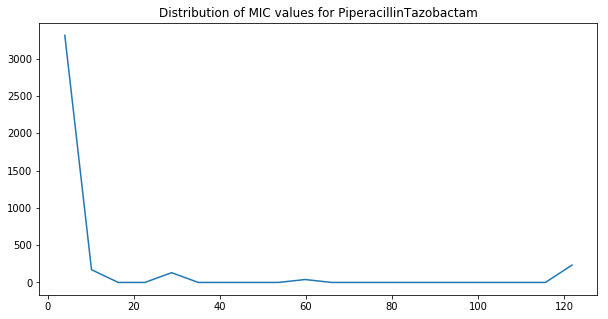

In [48]:
pyo_data.antibiotic_distribution_curve('PiperacillinTazobactam', bins=20)

In [49]:
pyo_data.antibiotic_timeseries('PiperacillinTazobactam')

,Mean MIC,SD
isolate_date,,
2015-03-31,15.736264,30.514417
2015-04-30,13.540984,23.360328
2015-05-31,21.937500,38.013622
2015-06-30,11.963636,23.571063
2015-07-31,15.295455,29.026947
2015-08-31,13.729167,25.060546
2015-09-30,NaN,NaN
2015-10-31,16.000000,31.532296
2015-11-30,13.272727,26.042922


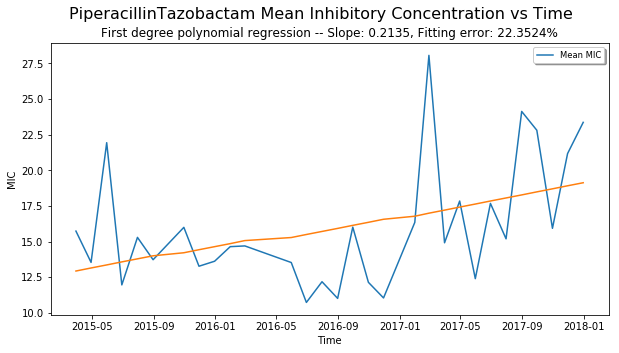

In [56]:
pyo_data.antibiotic_trend_analysis('PiperacillinTazobactam', include_sd=False)

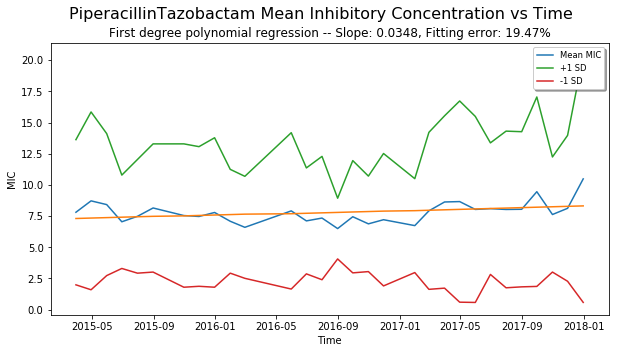

In [57]:
pyo_data.antibiotic_trend_analysis('PiperacillinTazobactam', remove_outliers=1)

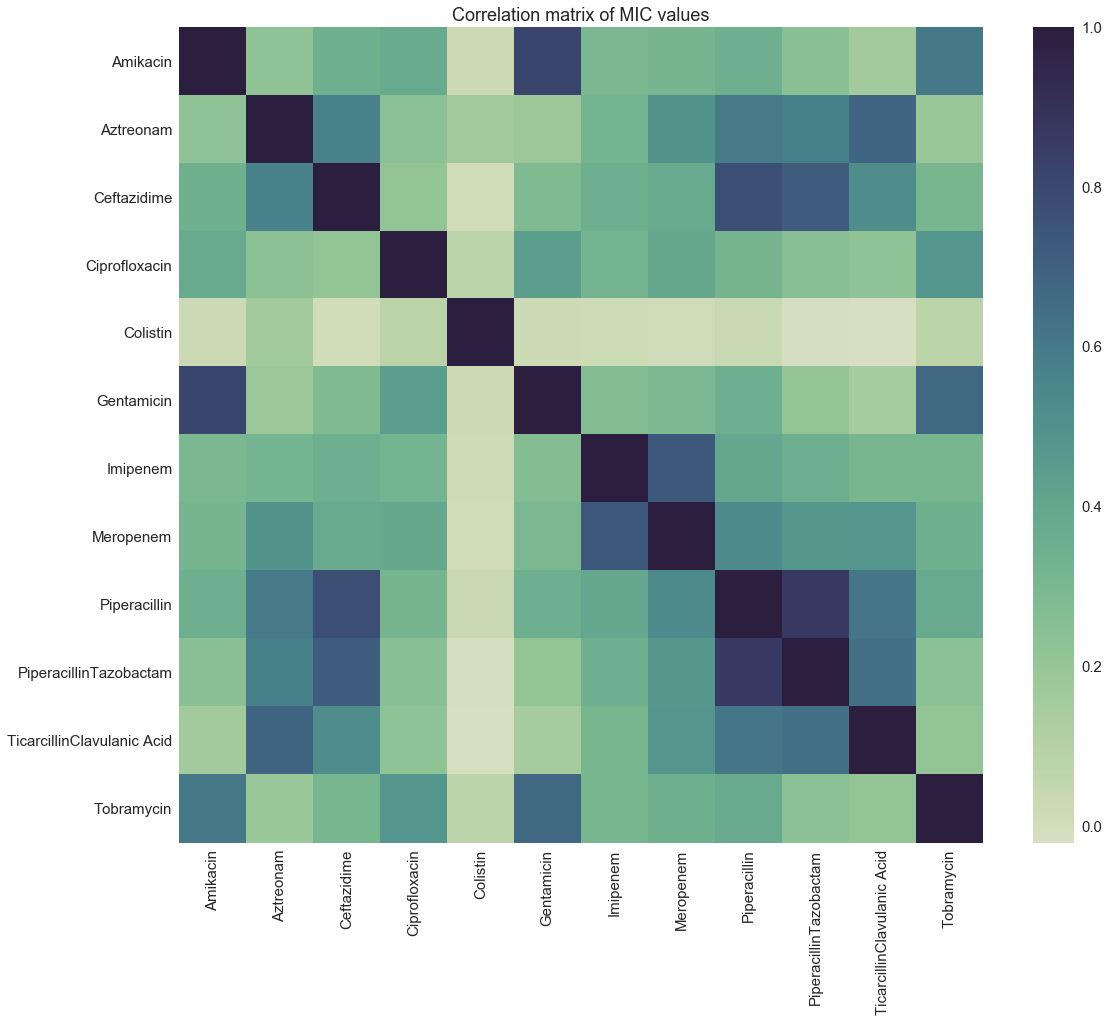

In [58]:
pyo_data.correlation_matrix()

<h2>Exploring the S.aureus data</h2>

In [79]:
staph_data = ProcessData(organism_mic_data_path='examples/staph_mic_data.pickle', start_date="2015-01-01", 
                         end_date="2018-01-01")

In [81]:
cipro = staph_data.antibiotic_descriptives('Ciprofloxacin')

In [82]:
cipro

{'Kurtosis': 6.5923152861407104,
 'Max MIC': 8.0,
 'Mean': 1.205756514974718,
 'Median MIC': 0.5,
 'Min MIC': 0.5,
 'Newest data point': numpy.datetime64('2017-12-14T00:00:00.000000000'),
 'Oldest data point': numpy.datetime64('2015-03-10T00:00:00.000000000'),
 'Sample variance': 4.2442743022203802,
 'Skewness': 2.8877521469065641,
 'Standard dev': 2.0601636590864278,
 'Total data points': 25710}

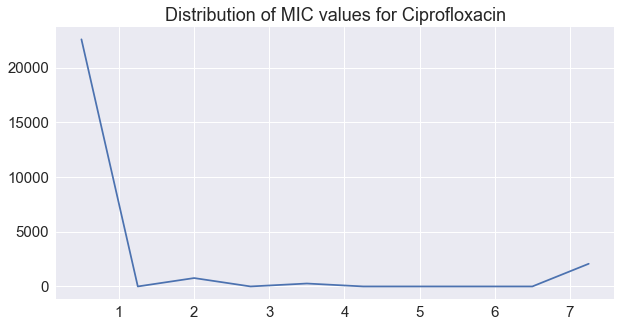

In [84]:
staph_data.antibiotic_distribution_curve('Ciprofloxacin', bins=10)

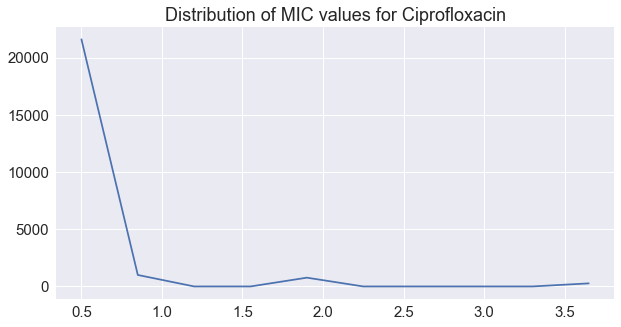

In [85]:
staph_data.antibiotic_distribution_curve('Ciprofloxacin', bins=10, remove_outliers=3)

In [86]:
staph_data.antibiotic_timeseries('Ciprofloxacin')

,Mean MIC,SD
isolate_date,,
2015-03-31,1.606782,2.557178
2015-04-30,1.370307,2.263963
2015-05-31,1.317671,2.195390
2015-06-30,1.177565,2.050652
2015-07-31,1.553114,2.480154
2015-08-31,1.353797,2.263073
2015-09-30,NaN,NaN
2015-10-31,1.305158,2.251277
2015-11-30,1.284751,2.183694


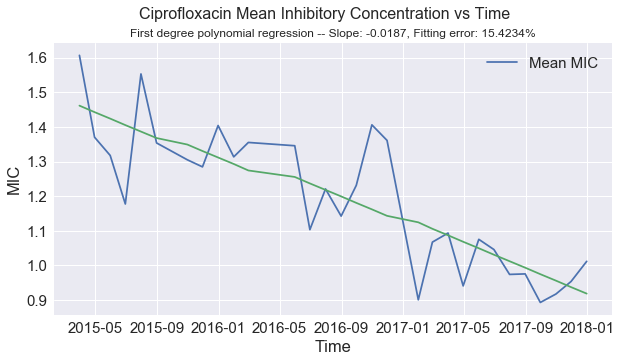

In [87]:
staph_data.antibiotic_trend_analysis('Ciprofloxacin', include_sd=False)

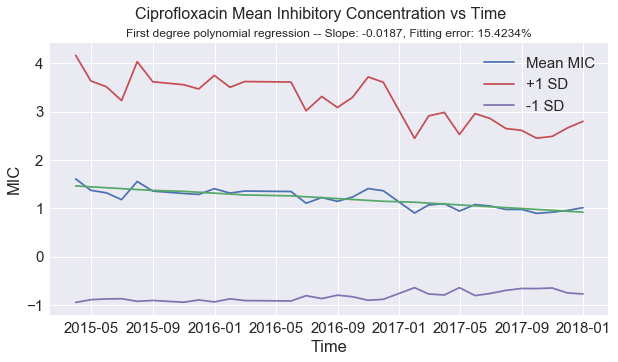

In [88]:
staph_data.antibiotic_trend_analysis('Ciprofloxacin')

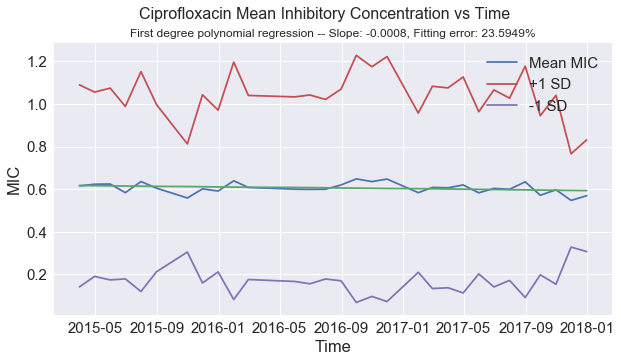

In [90]:
staph_data.antibiotic_trend_analysis('Ciprofloxacin', remove_outliers=3)

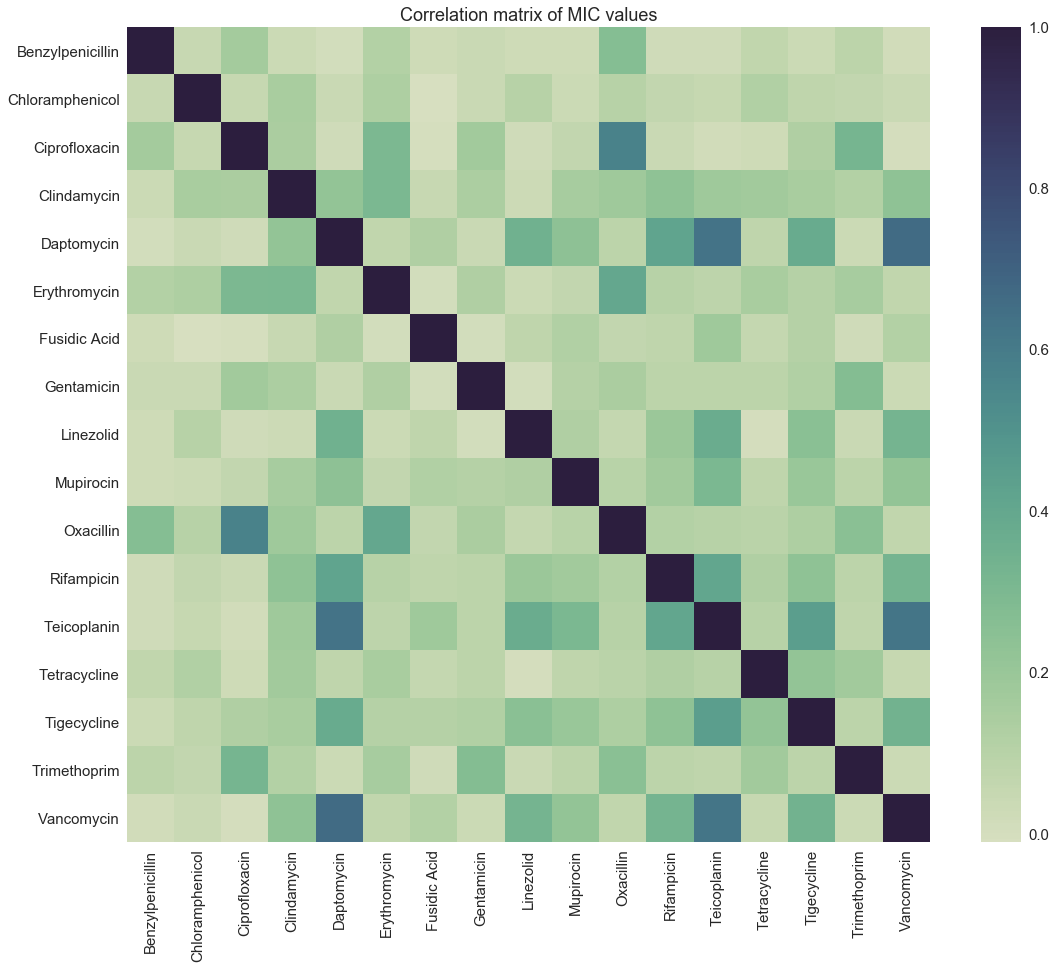

In [91]:
staph_data.correlation_matrix()